In [2]:
import os
import json
import random
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.neighbors import KernelDensity

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
# os.getcwd()

In [4]:
# load data
AMOC_Obs = pd.read_csv('input_data/dtdata_AMOC_Obs.csv', index_col = 0) # 1680 rows × 2 columns
AMOC_Ensemble = pd.read_csv('input_data/dtdata_AMOC_Ensemble.csv', index_col = 0) # 5988 rows × 29 columns

AMOCindex_Obs = pd.read_csv('input_data/dtdata_AMOCindex_Obs.csv', index_col = 0) # 1680 rows × 2 columns
AMOCindex_Ensemble = pd.read_csv('input_data/dtdata_AMOCindex_Ensemble.csv', index_col = 0) # 5988 rows × 29 columns

In [5]:
# Define a class to min-max scale the input data according to universe data, prevent certain dimension domian.
# Input should be a list of pandas dataframe, will be combined column-wise.
class Scaler:
    def __init__(self, data):
        data = pd.concat(data, axis = 1)

        self.min = data.min().min()
        self.max = data.max().max()

    def transform(self, X):
        return (X - self.min) / (self.max - self.min)
    
    # Transform data back to de-meaned version of original data: for further pre-processing, all data are de-meaned with pseudo-non-missing part of data. This function transform data back to
    # de-meaned version of original data. To transform back the long-term trend (output of model) should use this function too.
    def inverse_transform(self, X):
        return X * (self.max - self.min)

In [6]:
# Create scaled data for AMOC

AMOC_scaler = Scaler([AMOC_Obs[['Obs']], AMOC_Ensemble[[str(i) for i in range(1, 29)]]])
# copy(): The copy() method creates a shallow copy of a DataFrame. This means that the new object points 
# to the same data as the original object. Any changes made to the copy will affect the original object.
# The copy(deep = True) method creates a deep copy of a DataFrame. This means that the new object has its own 
# copy of the data. Changes made to the copy will not affect the original object.
AMOC_Obs_std = AMOC_Obs.copy(deep = True)
AMOC_Ensemble_std = AMOC_Ensemble.copy(deep = True)

AMOC_Obs_std[['Obs']] = AMOC_scaler.transform(AMOC_Obs_std[['Obs']])
AMOC_Ensemble_std[[str(i) for i in range(1, 29)]] = AMOC_scaler.transform(AMOC_Ensemble_std[[str(i) for i in range(1, 29)]])

In [7]:
# Create scaled data for AMOC index

AMOCindex_scaler = Scaler([AMOCindex_Obs[['Obs']], AMOCindex_Ensemble[[str(i) for i in range(1, 29)]]])

AMOCindex_Obs_std = AMOCindex_Obs.copy(deep = True)
AMOCindex_Ensemble_std = AMOCindex_Ensemble.copy(deep = True)

AMOCindex_Obs_std[['Obs']] = AMOCindex_scaler.transform(AMOCindex_Obs_std[['Obs']])
AMOCindex_Ensemble_std[[str(i) for i in range(1, 29)]] = AMOCindex_scaler.transform(AMOCindex_Ensemble_std[[str(i) for i in range(1, 29)]])

In [8]:
# # check scaling by plotting
# i = 0
# a = AMOC_Ensemble.iloc[i:(i+1680),9]
# a_std = AMOC_Ensemble_std.iloc[i:(i+1680),9]

# plt.plot(a)
# # plt.plot(a_std)
# # plt.plot(a_std * (AMOC_scaler.max - AMOC_scaler.min) + AMOC_scaler.min)
# plt.plot(AMOC_scaler.inverse_transform(a_std))

In [9]:
# # set seed

# tf.random.set_seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)
# np.random.seed(seed)
# random.seed(seed)

seed = 1

In [10]:
# Generate input data to use in DVAE

# Randomly sample 6,000 different time segments from 499 years (5,988 data points) Ensemble data; for each time segment,
# there will be 28 different training examples. Total would be 6,000 * 28 = 168,000 data set.
num_select = 6000

AMOC = np.array(AMOC_Ensemble_std[[str(i) for i in range(1, 29)]])
AMOC_index = np.array(AMOCindex_Ensemble_std[[str(i) for i in range(1, 29)]])

Ensemble_length = AMOC.shape[0] # 5,988 (499 years)
Obs_length = len(AMOC_Obs_std) # 1,680 (140 years)
mask = np.array(~AMOC_Obs_std['Obs'].isna()) # non-missing part in observation data

# start_list: List of start index of length 1,680 time segments from Ensemble data.
np.random.seed(seed)
start_list = [np.random.randint(0, Ensemble_length - Obs_length) for i in range(num_select)]

# AMOC_input: AMOC data corresponding to observation non-miss part.
# AMOCindex_input: AMOC Index data with same time segment corresponding to AMOC
# target: AMOC long term trend, generated from 2-degree polynomial fitting of 28 Ensemble trails to filter out nature variability.
AMOC_input = []
AMOCindex_input = []
target = []

for start in start_list:
    AMOC_seg = AMOC[start:(start + Obs_length), :] # 1,680 * 28
    AMOC_seg_masked = AMOC_seg[mask, :] # 179 * 28
    
    # De-mean AMOC data with mean of non-missing part data, which corresponding to real-world data: only non-missing part is known.
    mean = AMOC_seg_masked.mean(axis = 0)
    AMOC_seg = AMOC_seg - mean
    AMOC_seg_masked = AMOC_seg_masked - mean
    
    # Fit 2-degree polynomial with 28 ensemble trails
    x = np.array(range(Obs_length))
    # ploy: Polynomial coefficients, highest power first.
    poly = np.polyfit(x.repeat(AMOC_seg.shape[1]), AMOC_seg.flatten(), 2)
    y = x**2 * poly[0] + x * poly[1] + poly[2]
    y = np.reshape(y, (y.shape[0], 1)) # 1,680 * 1
    y = y.repeat(AMOC_seg.shape[1], axis = 1) # 1,680 * 28

    # De-mean AMOC index data.
    AMOCindex_seg = AMOC_index[start:(start + Obs_length), :]
    mean = AMOCindex_seg.mean(axis = 0)
    AMOCindex_seg = AMOCindex_seg - mean
    
    # Reshape data to (number of trails, number of timesteps, dimension)
    AMOC_seg_masked = np.reshape(np.ravel(AMOC_seg_masked, order = 'F'), (AMOC_seg_masked.shape[1], AMOC_seg_masked.shape[0], 1))
    AMOCindex_seg = np.reshape(np.ravel(AMOCindex_seg, order = 'F'), (AMOCindex_seg.shape[1], AMOCindex_seg.shape[0], 1))
    y = np.reshape(np.ravel(y, order = 'F'), (y.shape[1], y.shape[0], 1))
    
    AMOC_input.append(AMOC_seg_masked)
    AMOCindex_input.append(AMOCindex_seg)
    target.append(y)
    
AMOC_input = np.vstack(AMOC_input)
AMOCindex_input = np.vstack(AMOCindex_input)
target = np.vstack(target)

In [11]:
print(AMOC_input.shape)
print(AMOCindex_input.shape)
print(target.shape)

(168000, 179, 1)
(168000, 1680, 1)
(168000, 1680, 1)


In [12]:
### TRAIN VALIDATION TEST SPLIT : 0.6/0.2/0.2

# AMOC_input_train, AMOC_input_test = tf.split(
#     tf.random.shuffle(AMOC_input, seed = seed), [AMOC_input.shape[0] * 0.8, AMOC_input.shape[0] * 0.2], axis=0
# )

# TRAIN TEST SPLIT: 0.8/0.2
AMOC_input_train, AMOC_input_test, AMOCindex_input_train, AMOCindex_input_test, target_train, target_test = train_test_split(AMOC_input, AMOCindex_input, target, test_size=0.2, random_state=seed)

# TRAIN VALIDATION SPLIT with TRAIN: 0.75/0.25
AMOC_input_train, AMOC_input_val, AMOCindex_input_train, AMOCindex_input_val, target_train, target_val = train_test_split(AMOC_input_train, AMOCindex_input_train, target_train, test_size=0.25, random_state=seed)

In [13]:
print(AMOC_input_train.shape)
print(AMOC_input_val.shape)
print(AMOC_input_test.shape)

(100800, 179, 1)
(33600, 179, 1)
(33600, 179, 1)


In [14]:
### UTILITY FUNCTIONS FOR VAE CREATION ###

def sampling(args):
    # z_log_sigma: log sigma^2, this way could guarantee sigma^2 to be positive
    z_mean, z_log_sigma = args
    batch_size = tf.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(batch_size, tf.shape(z_mean)[1], tf.shape(z_mean)[2]), mean=0., stddev=1.)

    return z_mean + K.exp(0.5 * z_log_sigma) * epsilon

def vae_loss(original, out, z_mean, z_log_sigma, tuning1=1.0, tuning2=1.0, tuning3=1.0, tuning4=1.0):
    batch_size = tf.cast(tf.shape(z_mean)[0], tf.float32)
    
    diff1 = out[:, 1:, :] - out[:, :(-1), :]
    diff2 = diff1[:, 1:, :] - diff1[:, :(-1), :]
    
    # smoothness factor to help make output smooth, square diff of 0/1st/2nd order differentiation
    smoothness1 = K.mean(K.square(diff1)) * tuning1
    smoothness2 = K.mean(K.square(diff2)) * tuning2
    # SSE and KL-divergence.
    reconstruction = K.sum(K.square(original - out)) * tuning3
    kl = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)) * tuning4

    return (smoothness1 + smoothness2 + reconstruction + kl)/batch_size

def Conv1DTranspose(input_tensor, filters=8, kernel_size=60, strides=4, padding='same', activation='relu'):
    """
        Define de-convolutional layer use Conv2DTranspose
        
        input_tensor: tensor, with the shape (batch_size, time_steps, dims)
        filters: int, output dimension, i.e. the output tensor will have the shape of (batch_size, time_steps, filters)
        kernel_size: int, size of the convolution kernel
        strides: int, convolution step size
        padding: 'same' | 'valid'
    """
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
#     x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding, activation=activation)(x)
    x = Conv2DTranspose(filters, (kernel_size, 1), strides=(strides, 1), padding=padding, activation=activation)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

In [15]:
def get_model(shape_1, shape_2, shape_target, tuning4_para = 4.5):
    #latent_dim should be specified by conv1D output shape

    ### encoder ###
    
    inp_AMOC = Input(shape = shape_1) # (batch_size, 179, 1)
    inp_AMOCindex = Input(shape = shape_2) # (batch_size, 1680, 1)
    AMOC_target = Input(shape = shape_target) # (batch_size, 1680, 1)

    enc_AMOC_1 = Conv1D(filters=8, strides=4, kernel_size=60, activation='relu', padding='same', input_shape=(inp_AMOC.shape[1:]))(
        inp_AMOC) # (batch_size, 45, 8)
    enc_AMOC_2 = Conv1D(filters=8, strides=3, kernel_size=60, activation='relu', padding='same')(enc_AMOC_1) # (batch_size, 15, 8)
    enc_AMOC_3 = Conv1D(filters=8, strides=3, kernel_size=60, activation='relu', padding='same')(enc_AMOC_2) # (batch_size, 5, 8)

    enc_AMOCindex_1 = Conv1D(filters=8, strides=7, kernel_size=60, activation='relu', padding='same', input_shape=(inp_AMOCindex.shape[1:]))(
        inp_AMOCindex) # (batch_size, 240, 8)
    enc_AMOCindex_2 = Conv1D(filters=8, strides=4, kernel_size=60, activation='relu', padding='same')(enc_AMOCindex_1) # (batch_size, 60, 8)
    enc_AMOCindex_3 = Conv1D(filters=8, strides=4, kernel_size=60, activation='relu', padding='same')(enc_AMOCindex_2) # (batch_size, 15, 8)
    enc_AMOCindex_4 = Conv1D(filters=8, strides=3, kernel_size=60, activation='relu', padding='same')(enc_AMOCindex_3) # (batch_size, 5, 8)

    enc_out = Concatenate(axis=2)([enc_AMOC_3] + [enc_AMOCindex_4]) # (batch_size, 5, 16)

    z_mean = Dense(8)(enc_out) # (batch_size, 5, 8)
    z_log_sigma = Dense(8)(enc_out) # (batch_size, 5, 8)

    encoder = Model([inp_AMOC, inp_AMOCindex], [z_mean, z_log_sigma])

    ### decoder ###

    inp_z = Input(shape=z_mean.shape[1:]) # (batch_size, 5, 8)

    conv_1 = Conv1DTranspose(inp_z, filters=8, kernel_size=30, strides=7, padding='same', activation='relu') # (batch_size, 35, 8)
    conv_2 = Conv1DTranspose(conv_1, filters=8, kernel_size=60, strides=4, padding='same', activation='relu') # (batch_size, 140, 8)
    conv_3 = Conv1DTranspose(conv_2, filters=8, kernel_size=60, strides=4, padding='same', activation='relu') # (batch_size, 560, 8)
    conv_4 = Conv1DTranspose(conv_3, filters=8, kernel_size=60, strides=3, padding='same', activation='linear') # (batch_size, 1680, 8)

    out = Dense(1)(conv_4) # (batch_size, 1680, 1)

    decoder = Model([inp_z], [out])

    ### encoder + decoder ###

    z_mean, z_log_sigma = encoder([inp_AMOC, inp_AMOCindex])
    z = Lambda(sampling)([z_mean, z_log_sigma])
    pred = decoder([z])

    vae = Model([inp_AMOC, inp_AMOCindex, AMOC_target], pred)
    vae.add_loss(vae_loss(AMOC_target, pred, z_mean, z_log_sigma, tuning1=0, tuning2=0, tuning3=1.0, tuning4=tuning4_para))
    vae.compile(loss=None, optimizer=Adam(learning_rate=1e-3))

    return vae

para: 0
para: 1
para: 2
para: 3
para: 4
para: 5
para: 6


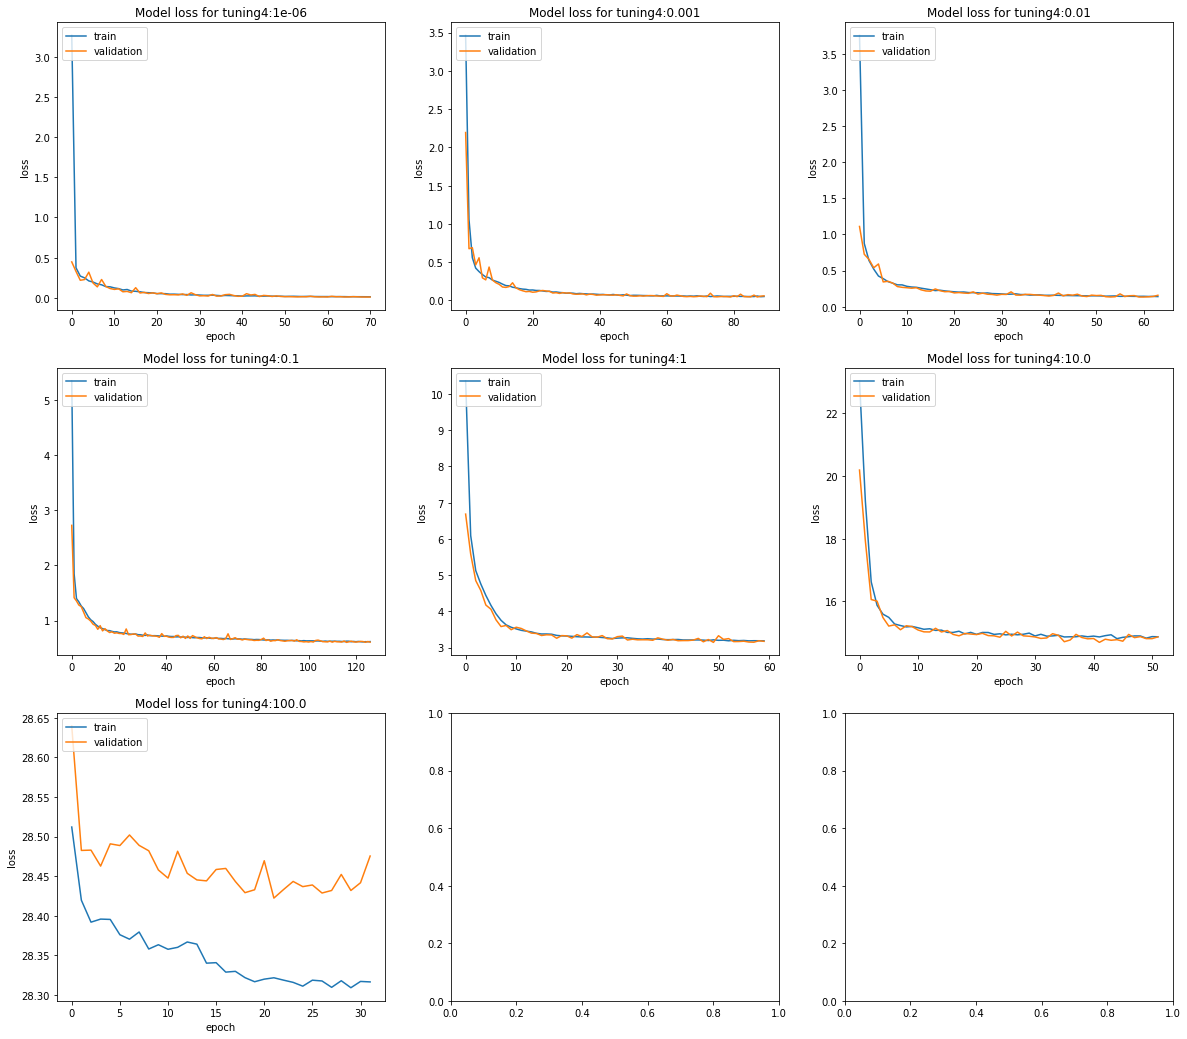

In [16]:
# Grid serach to find the best ratio between mse loss and KL-divergence in vae loss, the ratio is controlled by tuning parameter 4 in self-defined vae loss.
grid_result = {}

epoch_num = 150
verbose = 0
num_val_pred = 100
tuning4_grid = [1e-6, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2]

nrows = math.ceil(len(tuning4_grid)/3)
fig, axs = plt.subplots(nrows = nrows, ncols = 3, figsize = (20, 6*nrows))

for i, para in enumerate(tuning4_grid):
    print('para:', para)
    # fit the model
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    es = [
    EarlyStopping(patience=10, verbose=verbose, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True),
    ModelCheckpoint(filepath='hyper_tuning/beta_'+str(para)+'.hdf5', save_freq='epoch', save_best_only=True)]
    vae_model = get_model(AMOC_input_train.shape[1:], AMOCindex_input_train.shape[1:], target_train.shape[1:], tuning4_para = para)
    history = vae_model.fit([AMOC_input_train, AMOCindex_input_train, target_train], batch_size=128, epochs=epoch_num, validation_split=0.2, verbose=verbose, callbacks=es)
    
    # prediction on validation set
    val_pred = np.zeros((num_val_pred, target_val.shape[0], target_val.shape[1], target_val.shape[2]))
    for j in range(num_val_pred):
        val_pred[j, :, :, :] = AMOC_scaler.inverse_transform(vae_model.predict([AMOC_input_val, AMOCindex_input_val, np.zeros(target_val.shape)], verbose = 0))
#         if j%10 == 0:
#             print(j)
        
    # record summary statistics
    val_pred = np.squeeze(val_pred)
    mean = np.mean(val_pred, axis = 0)
    std = np.std(val_pred, axis = 0)

    grid_result[para] = [mean, std]
    
    # Visualize Model Training History
    axs[i//3, i%3].plot(history.history['loss'])
    axs[i//3, i%3].plot(history.history['val_loss'])
    axs[i//3, i%3].set_title('Model loss for tuning4:' + str(para))
    axs[i//3, i%3].set_ylabel('loss')
    axs[i//3, i%3].set_xlabel('epoch')
    axs[i//3, i%3].legend(['train', 'validation'], loc='upper left')

plt.show()

# fig.savefig('hyper_tuning/history.png', bbox_inches='tight')
# np.save('../model_output/grid_result.npy', grid_result)

In [16]:
# load grid_result file
grid_result = np.load('../model_output/grid_result.npy', allow_pickle=True)
grid_result = grid_result[()]

target = np.squeeze(AMOC_scaler.inverse_transform(target_val))

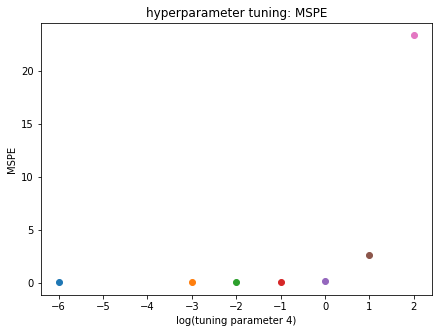

In [17]:
# plot mspe based on validation data
plt.figure(figsize=(7, 5))
for key in grid_result:
    val_pred_mean = grid_result[key][0]
    mspe = np.mean(np.square(target - val_pred_mean))
    plt.plot(math.log10(key), mspe, marker = 'o')
#     plt.plot(math.log10(key), math.log10(mspe), marker = 'o')
plt.title('hyperparameter tuning: MSPE')
plt.xlabel('log(tuning parameter 4)')
plt.ylabel('MSPE')
# plt.ylim((0, 2))
plt.show()

In [18]:
# plot empirical coverage based on validation data set

labels = []
emp_coverage = []
mae = []

for key in grid_result:
    # calculate empirical probability over validation data set
    mean = grid_result[key][0]
    std = grid_result[key][1]
    ci = 1.96 * std
    lower = mean - ci
    upper = mean + ci
    count = np.sum((target >= lower) & (target <= upper), axis = 1)
    emp_prob = count/target_val.shape[1] # len(emp_prob): 33,600
    
    # calculate mae over validation data set
    val_bias = np.mean(np.absolute(target - mean), axis=1) # len(val_bias): 33,600
    
    labels.append(math.log10(key))
    emp_coverage.append(emp_prob)
    mae.append(val_bias)

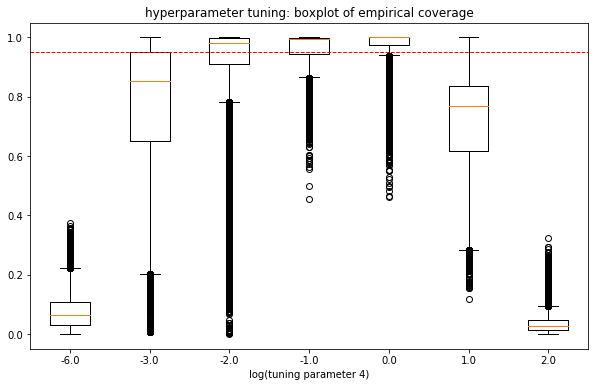

In [19]:
# plot empirical coverage based on validation data set
plt.figure(figsize=(10, 6))
plt.boxplot(emp_coverage,
            positions=list(range(len(labels))),
            labels=labels)
plt.axhline(y=0.95, color='red', linestyle='--', lw=1)
plt.title('hyperparameter tuning: boxplot of empirical coverage')
plt.xlabel('log(tuning parameter 4)')
plt.show()

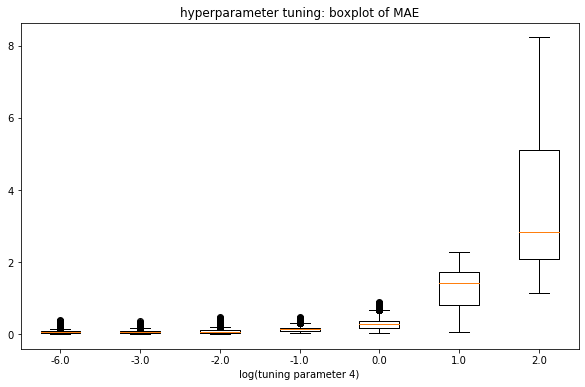

In [20]:
# plot empirical coverage based on validation data set
plt.figure(figsize=(10, 6))
plt.boxplot(mae,
            positions=list(range(len(labels))),
            labels=labels)
plt.title('hyperparameter tuning: boxplot of MAE')
plt.xlabel('log(tuning parameter 4)')
plt.show()

In [21]:
best_para = 1e-1

In [22]:
# path to save model output: folder 'model_output' will not be shown on git 
# repo as the file is large, no need to git it.
file = '../model_output/beta_' + str(best_para) + '/'

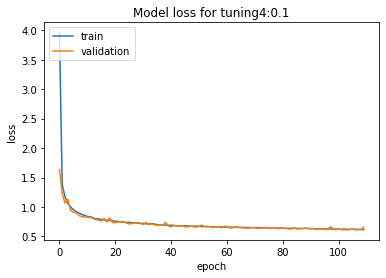

In [27]:
# train model with best hyper parameter

# combine training and validation data
AMOC_input_train = np.concatenate((AMOC_input_train, AMOC_input_val), axis = 0)
AMOCindex_input_train = np.concatenate((AMOCindex_input_train, AMOCindex_input_val), axis = 0)
target_train = np.concatenate((target_train, target_val), axis = 0)

# train model
epoch_num = 150
verbose = 0

tf.keras.backend.clear_session()
tf.random.set_seed(seed)
es = [
EarlyStopping(patience=10, verbose=verbose, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True),
ModelCheckpoint(filepath='hyper_tuning/best_model_beta_'+str(best_para)+'.hdf5', save_freq='epoch', save_best_only=True)]
vae = get_model(AMOC_input_train.shape[1:], AMOCindex_input_train.shape[1:], target_train.shape[1:], tuning4_para = best_para)
history = vae.fit([AMOC_input_train, AMOCindex_input_train, target_train], batch_size=128, epochs=epoch_num, validation_split=0.2, verbose=verbose, callbacks=es)

# Visualize Model Training History
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss for tuning4:' + str(best_para))
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# np.save(file + 'history.npy', history.history)

In [ ]:
# ATTENTION: prediction for test data set 'test_pred' need 421. GiB memory, 
# ensure have enough space.

In [ ]:
vae = load_model('hyper_tuning/best_model_beta_'+str(best_para)+'.hdf5')

# Pred testing data set, prediction results should be in original scale
test_pred = np.zeros((1000, target_test.shape[0], target_test.shape[1], target_test.shape[2]))

tf.random.set_seed(seed+1)
for i in range(1000):
    test_pred[i, :, :, :] = AMOC_scaler.inverse_transform(vae.predict([AMOC_input_test, AMOCindex_input_test, np.zeros(target_test.shape)], verbose = 0))
    
    if i%100 == 0:
        print(i)

0
100
200
300
400
500
600
700
800


In [ ]:
# # ATTENTION: prediction for test data set 'test_pred' need 421. GiB memory, 
# # ensure have enough space.

# np.save(file + 'test_pred.npy', test_pred)

[]

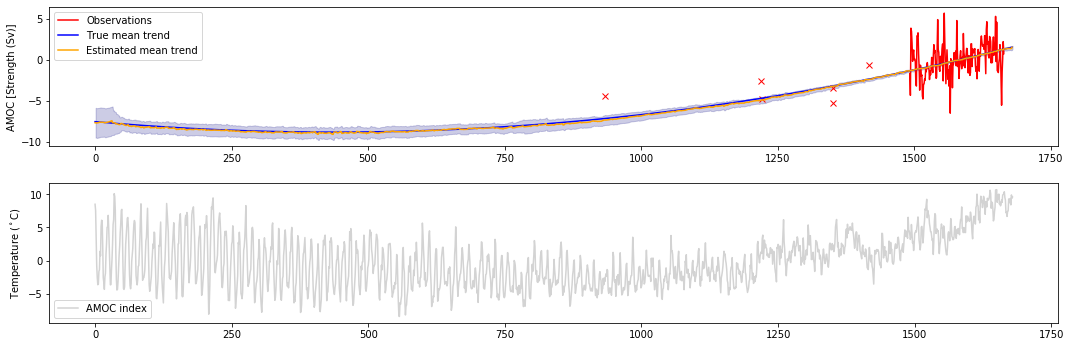

In [57]:
# # plot some case in testing data set

# i = 12000

# test_pred_1000 = test_pred[:, i, :, :]
# AMOC_input_test_0 = AMOC_scaler.inverse_transform(AMOC_input_test[i, :, :])
# AMOCindex_input_test_0 = AMOC_scaler.inverse_transform(AMOCindex_input_test[i, :, :])
# target_test_0 = AMOC_scaler.inverse_transform(target_test[i, :, :])

# test_pred_1000 = np.squeeze(test_pred_1000)
# AMOC_input_test_0 = np.squeeze(AMOC_input_test_0)
# AMOCindex_input_test_0 = np.squeeze(AMOCindex_input_test_0)
# target_test_0 = np.squeeze(target_test_0)

# ### confidence interval ###
# test_pred_1000 = np.squeeze(test_pred_1000)
# mean = np.mean(test_pred_1000, axis=0)
# std = np.std(test_pred_1000, axis=0)
# x = np.linspace(1, test_pred_1000.shape[1], test_pred_1000.shape[1])
# ci = 1.96 * std

# mask = np.array(~AMOC_Obs['Obs'].isna())

# foo = plt.figure(figsize=(15, 5))
# plt.subplot(2, 1, 1)
# plt.tight_layout(pad = 2)
# for j in range(6):
#     plt.plot(x[mask][j], AMOC_input_test_0[j], c='red', marker='x')
# plt.plot(x[mask][6:], AMOC_input_test_0[6:], c='red', label='Observations')
# plt.plot(target_test_0, c='blue', label='True mean trend')
# plt.plot(mean, c='orange', label='Estimated mean trend')
# plt.fill_between(x, (mean-ci), (mean+ci), color='navy', alpha=.2)
# plt.ylabel(r'AMOC [Strength (Sv)]')
# plt.legend()

# plt.subplot(2, 1, 2)
# plt.plot(AMOCindex_input_test_0, c='lightgray', label='AMOC index')
# plt.ylabel('Temperature ($^\circ$C)')
# plt.legend()

# plt.plot()

In [58]:
# # save some representative testing data case
# for i in [400, 600, 1000, 1700, 3000, 10000]:
#     np.save(file + 'test_pred_'+str(i)+'.npy', test_pred[:, i, :, :])
#     np.save(file + 'AMOC_input_test_'+str(i)+'.npy', AMOC_scaler.inverse_transform(AMOC_input_test[i, :, :]))
#     np.save(file + 'AMOCindex_input_test_'+str(i)+'.npy', AMOC_scaler.inverse_transform(AMOCindex_input_test[i, :, :]))
#     np.save(file + 'target_test_'+str(i)+'.npy', AMOC_scaler.inverse_transform(target_test[i, :, :]))

In [59]:
### pred Observation data, prediction results should be in original scale ###
AMOC_Obs = np.array(AMOC_Obs_std.loc[~AMOC_Obs_std['Obs'].isna(), 'Obs']).reshape((1, -1, 1))
AMOC_Obs = AMOC_Obs - AMOC_Obs.mean()

AMOCindex_Obs = np.array(AMOCindex_Obs_std[['Obs']]).reshape((1, -1, 1))
AMOCindex_Obs = AMOCindex_Obs - AMOCindex_Obs.mean()

Obs_pred = np.zeros((1000, target_test.shape[1], target_test.shape[2]))

tf.random.set_seed(seed+2)
for i in range(1000):
    Obs_pred_0 = AMOC_scaler.inverse_transform(vae.predict([AMOC_Obs, AMOCindex_Obs, np.zeros((1, target_test.shape[1], target_test.shape[2]))], verbose = 0))
    Obs_pred[i, :, :] = np.squeeze(Obs_pred_0, axis = 0)

In [60]:
# np.save(file + 'Obs_pred.npy', Obs_pred)

In [61]:
# Get emp_prob: for each testing data set, find confidence interval over 1,000 trails prediction generated from vae, check if target value is in constructed confidence interval. 
# The ideal empircal probability should be 0.95 as we are constructing 95% CI.
target = np.squeeze(AMOC_scaler.inverse_transform(target_test)) # shape: (33,600, 1,680)
test_pred_1000 = np.squeeze(test_pred) # shape: (1,000, 33,600, 1,680)

# emp_prob
mean = np.mean(test_pred_1000, axis=0)
std = np.std(test_pred_1000, axis=0)
ci = 1.96 * std
lower = mean - ci
upper = mean + ci
count = np.sum((target >= lower) & (target <= upper), axis = 1)
emp_prob = count/target_test.shape[1] # shape: (33,600, )

# bias
test_bias = target - mean # shape: (33,600, 1,680)

In [62]:
np.save(file + 'emp_prob.npy', emp_prob)
np.save(file + 'test_bias.npy', test_bias)
np.save(file + 'test_pred_mean.npy', mean)
np.save(file + 'test_pred_std.npy', std)